# Image classification

Image classification assigns a class label to an image. Unlike text or audio classification, the inputs are the
pixel values that comprise an image. There are many applications for image classification. This notebook illustrates how to:

1. Fine-tune a [Data-efficient image Transformers (DeiT)](https://huggingface.co/docs/transformers/en/model_doc/deit) on the [Fashion MNIST](https://huggingface.co/datasets/fashion_mnist) dataset to classify a Zalando's article in an image.  DeiTs are more efficiently trained transformers for image classification, requiring far less data and far less computing resources compared to the original [Vision Transformer](https://huggingface.co/docs/transformers/en/model_doc/vit) models.

2. Use your fine-tuned model for inference.



In [ ]:
!pip install transformers datasets evaluate

## Load Fashion MNIST dataset

Start by loading the Fashion MNIST dataset from the Datasets library.

In [111]:
from datasets import load_dataset

fashion = load_dataset("fashion_mnist")
fashion

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [112]:
fashion["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In this example, the trainSplit the dataset's `train` split into a train and test set with the [train_test_split](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.train_test_split) method:

In [120]:
splits = fashion["train"].train_test_split(test_size=0.001, train_size=0.01, seed=13)
print(splits)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 600
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 60
    })
})


In [121]:
tr_fashion = splits['train']
dv_fashion = splits['test']
te_fashion = fashion['test']

In [122]:
print(tr_fashion)

Dataset({
    features: ['image', 'label'],
    num_rows: 600
})


Then take a look at an example:

In [123]:
tr_fashion[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7F634E0A1EE0>,
 'label': 0}

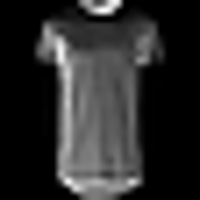

In [126]:
display(tr_fashion[0]["image"].resize((200, 200)))

Each example in the dataset has two fields:

- `image`: a PIL image of the fashion item
- `label`: the label class of the fashion item

To make it easier for the model to get the label name from the label id, create a dictionary that maps the label name
to an integer and vice versa:

In [124]:
labels = tr_fashion.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

Now you can convert the label id to a label name:

In [125]:
id2label[7]

'Sneaker'

## Preprocess

Before we can feed these images to our model, we need to preprocess them. 

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

In addition, one typically performs what is called **data augmentation** during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data.

We will use `torchvision.transforms` for the image transformations/data augmentation in this tutorial, but note that one can use any other package (like [albumentations](https://albumentations.ai/), [imgaug](https://github.com/aleju/imgaug), [Kornia](https://kornia.readthedocs.io/en/latest/) etc.).

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called a feature extractor with the `AutoFeatureExtractor.from_pretrained` method.

This feature extractor is a minimal preprocessor that can be used to prepare images for inference.

In [ ]:
from transformers import AutoFeatureExtractor

checkpoint = "facebook/deit-tiny-patch16-224"
feature_extractor = AutoFeatureExtractor.from_pretrained(checkpoint)
feature_extractor

The Datasets library is made for processing data very easily. We can write custom functions, which can then be applied on an entire dataset (either using [`.map()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=map#datasets.Dataset.map) or [`.set_transform()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)).

Here we define 2 separate functions, one for training (which includes data augmentation) and one for validation (which only includes resizing, center cropping and normalizing).

In [88]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop((feature_extractor.size['height'],feature_extractor.size['width'])),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

dev_transforms = Compose(
        [
            Resize((feature_extractor.size['height'],feature_extractor.size['width'])),
            CenterCrop((feature_extractor.size['height'],feature_extractor.size['width'])),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_dev(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [dev_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

Next, we can preprocess our dataset by applying these functions. We will use the set_transform functionality, which allows to apply the functions above on-the-fly (meaning that they will only be applied when the images are loaded in RAM).

In [127]:
tr_fashion.set_transform(preprocess_train)
dv_fashion.set_transform(preprocess_dev)

Let's access an element to see that we've added a "pixel_values" feature:

In [94]:
tr_fashion[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7F635307AF70>,
 'label': 7,
 'pixel_values': tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.9843, -0.9843, -0.9843,  ..., -0.8196, -0.8196, -0.8196],
          [-0.9843, -0.9843, -0.9843,  ..., -0.8196, -0.8196, -0.8196],
          [-0.9843, -0.9843, -0.9843,  ..., -0.8196, -0.8196, -0.8196]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.9843, -0.9843, -0.9843,  ..., -0.8196, -0.8196, -0.8196],
          [-0.9843, -0.9843, -0.9843,  ..., -0.8196, -0.8196, -0.8196],
          [-0.9843, -0.9843, -0.9843,  ..., -0.8196, -0.819

The next step is to load a ViT image processor to process the image into a tensor:

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `AutoModelForImageClassification` class. Calling the `from_pretrained` method on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom classification head will be created (with a custom number of output neurons).

NOTE: in case you're planning to fine-tune an already fine-tuned checkpoint, like [facebook/convnext-tiny-224](https://huggingface.co/facebook/convnext-tiny-224) (which has already been fine-tuned on ImageNet-1k), then you need to provide the additional argument `ignore_mismatched_sizes=True` to the `from_pretrained` method. This will make sure the output head (with 1000 output neurons) is thrown away and replaced by a new, randomly initialized classification head that includes a custom number of output neurons. You don't need to specify this argument in case the pre-trained model doesn't include a head. 

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


The warning is telling us we are throwing away some weights (the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

In [129]:
model_name = checkpoint.split("/")[-1]
batch_size = 32 # batch size for training and evaluation

args = TrainingArguments(
    f"{model_name}-finetuned-fashion",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument `push_to_hub` allows the Trainer to push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally with a name that is different from the name of the repository, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"nielsr/vit-finetuned-cifar10"` or `"huggingface/nielsr/vit-finetuned-cifar10"`).

Let us also load the Accuracy metric, which we'll use to evaluate our model both during and after training.

In [132]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-132-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [133]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [102]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [130]:
trainer = Trainer(
    model,
    args,
    train_dataset=tr_fashion,
    eval_dataset=dv_fashion,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Now we can finetune our model by calling the `train` method:

In [134]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** Running training *****
  Num examples = 600
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 12
  Number of trainable parameters = 5526346


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,1.636118,0.483333
1,No log,1.481568,0.500000
2,1.962300,1.481568,0.500000


***** Running Evaluation *****
  Num examples = 60
  Batch size = 32


Epoch,Training Loss,Validation Loss


Saving model checkpoint to deit-tiny-patch16-224-finetuned-fashion/checkpoint-4
Configuration saved in deit-tiny-patch16-224-finetuned-fashion/checkpoint-4/config.json
Model weights saved in deit-tiny-patch16-224-finetuned-fashion/checkpoint-4/pytorch_model.bin
Image processor saved in deit-tiny-patch16-224-finetuned-fashion/checkpoint-4/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 60
  Batch size = 32
Saving model checkpoint to deit-tiny-patch16-224-finetuned-fashion/checkpoint-8
Configuration saved in deit-tiny-patch16-224-finetuned-fashion/checkpoint-8/config.json
Model weights saved in deit-tiny-patch16-224-finetuned-fashion/checkpoint-8/pytorch_model.bin
Image processor saved in deit-tiny-patch16-224-finetuned-fashion/checkpoint-8/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 60
  Batch size = 32
Saving model checkpoint to deit-tiny-patch16-224-finetuned-fashion/checkpoint-12
Configuration saved in deit-tiny-patch16-224-finetu

***** train metrics *****
  epoch                    =       2.84
  total_flos               = 10747181GF
  train_loss               =     1.9008
  train_runtime            = 0:05:43.88
  train_samples_per_second =      5.234
  train_steps_per_second   =      0.035


In [138]:
# prepare image for the model
encoding = feature_extractor(te_fashion[0]["image"].convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [139]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(**encoding)
  logits = outputs.logits

In [140]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: Ankle boot


In [142]:
actual_class_idx = te_fashion[0]["label"]
print("Actual class:", model.config.id2label[actual_class_idx])

Actual class: Ankle boot


## OLD CODE

In [ ]:
from transformers import AutoImageProcessor

checkpoint = "facebook/deit-tiny-patch16-224"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Apply some image transformations to the images to make the model more robust against overfitting. Here you'll use torchvision's [`transforms`](https://pytorch.org/vision/stable/transforms.html) module, but you can also use any image library you like.

Crop a random part of the image, resize it, and normalize it with the image mean and standard deviation:

In [51]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

Then create a preprocessing function to apply the transforms and return the `pixel_values` - the inputs to the model - of the image:

In [52]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

To apply the preprocessing function over the entire dataset, use 🤗 Datasets [with_transform](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.with_transform) method. The transforms are applied on the fly when you load an element of the dataset:

In [53]:
fashions_exps = fashion_exps.with_transform(transforms)

Now create a batch of examples using [DefaultDataCollator](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DefaultDataCollator). Unlike other data collators in 🤗 Transformers, the `DefaultDataCollator` does not apply additional preprocessing such as padding.

In [54]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

## Evaluate

Including a metric during training is often helpful for evaluating your model's performance. You can quickly load an
evaluation method with the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library. For this task, load
the [accuracy](https://huggingface.co/spaces/evaluate-metric/accuracy) metric (see the 🤗 Evaluate [quick tour](https://huggingface.co/docs/evaluate/a_quick_tour) to learn more about how to load and compute a metric):

In [55]:
import evaluate

accuracy = evaluate.load("accuracy")

Then create a function that passes your predictions and labels to [compute](https://huggingface.co/docs/evaluate/main/en/package_reference/main_classes#evaluate.EvaluationModule.compute) to calculate the accuracy:

In [56]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

Your `compute_metrics` function is ready to go now, and you'll return to it when you set up your training.

## Train

<Tip>

If you aren't familiar with finetuning a model with the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer), take a look at the basic tutorial [here](https://huggingface.co/docs/transformers/main/en/tasks/../training#train-with-pytorch-trainer)!

</Tip>

You're ready to start training your model now! Load ViT with [AutoModelForImageClassification](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForImageClassification). Specify the number of labels along with the number of expected labels, and the label mappings:

In [63]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--deit-tiny-patch16-224/snapshots/b3428f18dcc7b543470d07f14b4a4157815d1880/config.json
Model config ViTConfig {
  "_name_or_path": "facebook/deit-tiny-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 192,
  "id2label": {
    "0": "T - shirt / top",
    "1": "Trouser",
    "2": "Pullover",
    "3": "Dress",
    "4": "Coat",
    "5": "Sandal",
    "6": "Shirt",
    "7": "Sneaker",
    "8": "Bag",
    "9": "Ankle boot"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 768,
  "label2id": {
    "Ankle boot": "9",
    "Bag": "8",
    "Coat": "4",
    "Dress": "3",
    "Pullover": "2",
    "Sandal": "5",
    "Shirt": "6",
    "Sneaker": "7",
    "T - shirt / top": "0",
    "Trouser": "1"
  },
  "layer_norm_eps": 1e

At this point, only three steps remain:

1. Define your training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments). It is important you don't remove unused columns because this'll drop the `image` column. Without the `image` column, you can't create `pixel_values`. Set `remove_unused_columns=False` to prevent this behavior! The only other required parameter is `output_dir` which specifies where to save your model. You'll push this model to the Hub by setting `push_to_hub=True` (you need to be signed in to Hugging Face to upload your model). At the end of each epoch, the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) will evaluate the accuracy and save the training checkpoint.
2. Pass the training arguments to [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, tokenizer, data collator, and `compute_metrics` function.
3. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

In [64]:
training_args = TrainingArguments(
    output_dir="model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 60000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 937
  Number of trainable parameters = 5526346


RuntimeError: ignored

## Inference

Great, now that you've fine-tuned a model, you can use it for inference!

Load an image you'd like to run inference on:

In [35]:
ds = load_dataset("food101", split="validation[:10]")
image = ds["image"][0]

In [ ]:
from transformers import pipeline

classifier = pipeline("image-classification", model="model")
classifier(image)

You can also manually replicate the results of the `pipeline` if you'd like:

Load an image processor to preprocess the image and return the `input` as PyTorch tensors:

In [ ]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("model")
inputs = image_processor(image, return_tensors="pt")

Pass your inputs to the model and return the logits:

In [ ]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("model")
with torch.no_grad():
    logits = model(**inputs).logits

Get the predicted label with the highest probability, and use the model's `id2label` mapping to convert it to a label:

In [ ]:
predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]

'beignets'